# Convolutional Neural Network Example

Build a convolutional neural network with TensorFlow v2.

This example is using a low-level approach to better understand all mechanics behind building convolutional neural networks and the training process.

- Author: Aymeric Damien
- Project: https://github.com/aymericdamien/TensorFlow-Examples/

## CNN Overview

![CNN](http://personal.ie.cuhk.edu.hk/~ccloy/project_target_code/images/fig3.png)

## MNIST Dataset Overview

This example is using MNIST handwritten digits. The dataset contains 60,000 examples for training and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 255. 

In this example, each image will be converted to float32 and normalized to [0, 1].

![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)

More info: http://yann.lecun.com/exdb/mnist/

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
tf.data.Dataset.cache
tf.data.Dataset.prefetch

<function tensorflow.python.data.ops.dataset_ops.DatasetV2.prefetch(self, buffer_size, name=None)>

In [4]:
# MNIST dataset parameters.
num_classes = 10 # total classes (0-9 digits).

# Training parameters.
learning_rate = 0.001
training_steps = 200
batch_size = 128
display_step = 10

# Network parameters.
conv1_filters = 32 # number of filters for 1st conv layer.
conv2_filters = 64 # number of filters for 2nd conv layer.
fc1_units = 1024 # number of neurons for 1st fully-connected layer.

In [5]:
# Prepare MNIST data.
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

In [6]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [7]:
# Create some wrappers for simplicity.
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation.
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    # MaxPool2D wrapper.
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

In [8]:
# Store layers weight & bias

# A random value generator to initialize weights.
random_normal = tf.initializers.RandomNormal(seed = 1)

weights = {
    # Conv Layer 1: 5x5 conv, 1 input, 32 filters (MNIST has 1 color channel only).
    'wc1': tf.Variable(random_normal([5, 5, 1, conv1_filters])),
    # Conv Layer 2: 5x5 conv, 32 inputs, 64 filters.
    'wc2': tf.Variable(random_normal([5, 5, conv1_filters, conv2_filters])),
    # FC Layer 1: 7*7*64 inputs, 1024 units.
    'wd1': tf.Variable(random_normal([7*7*64, fc1_units])),
    # FC Out Layer: 1024 inputs, 10 units (total number of classes)
    'out': tf.Variable(random_normal([fc1_units, num_classes]))
}

biases = {
    'bc1': tf.Variable(tf.zeros([conv1_filters])),
    'bc2': tf.Variable(tf.zeros([conv2_filters])),
    'bd1': tf.Variable(tf.zeros([fc1_units])),
    'out': tf.Variable(tf.zeros([num_classes]))
}

In [9]:
# Create model
def conv_net(x):
    
    # Input shape: [-1, 28, 28, 1]. A batch of 28x28x1 (grayscale) images.
    x = tf.reshape(x, [-1, 28, 28, 1])

    # Convolution Layer. Output shape: [-1, 28, 28, 32].
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    
    # Max Pooling (down-sampling). Output shape: [-1, 14, 14, 32].
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer. Output shape: [-1, 14, 14, 64].
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    
    # Max Pooling (down-sampling). Output shape: [-1, 7, 7, 64].
    conv2 = maxpool2d(conv2, k=2)

    # Reshape conv2 output to fit fully connected layer input, Output shape: [-1, 7*7*64].
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    
    # Fully connected layer, Output shape: [-1, 1024].
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    # Apply ReLU to fc1 output for non-linearity.
    fc1 = tf.nn.relu(fc1)

    # Fully connected layer, Output shape: [-1, 10].
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    # Apply softmax to normalize the logits to a probability distribution.
    return tf.nn.softmax(out)

In [10]:
# Cross-Entropy loss function.
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)
    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    # Compute cross-entropy.
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

# ADAM optimizer.
optimizer = tf.optimizers.Adam(learning_rate)

In [11]:
# Optimization process. 
def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        pred = conv_net(x)
        loss = cross_entropy(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = list(weights.values()) + list(biases.values())

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [12]:
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = conv_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 10, loss: 83.767975, accuracy: 0.843750
step: 20, loss: 24.863878, accuracy: 0.937500
step: 30, loss: 40.941124, accuracy: 0.882812
step: 40, loss: 25.677141, accuracy: 0.945312
step: 50, loss: 18.441093, accuracy: 0.937500
step: 60, loss: 17.436888, accuracy: 0.960938
step: 70, loss: 22.778542, accuracy: 0.960938
step: 80, loss: 15.600732, accuracy: 0.976562
step: 90, loss: 13.412257, accuracy: 0.968750
step: 100, loss: 12.422983, accuracy: 0.968750
step: 110, loss: 5.208853, accuracy: 0.984375
step: 120, loss: 12.525060, accuracy: 0.960938
step: 130, loss: 18.631781, accuracy: 0.953125
step: 140, loss: 3.651477, accuracy: 0.992188
step: 150, loss: 5.057397, accuracy: 0.992188
step: 160, loss: 6.999191, accuracy: 0.976562
step: 170, loss: 11.555661, accuracy: 0.953125
step: 180, loss: 6.002543, accuracy: 0.984375
step: 190, loss: 8.590278, accuracy: 0.984375
step: 200, loss: 7.141659, accuracy: 0.984375


In [17]:
# Test model on validation set.
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.batch(500)
for (x_test, y_test) in test_data:
    pred = conv_net(x_test)
    print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.976000


In [18]:
# Visualize predictions.
import matplotlib.pyplot as plt

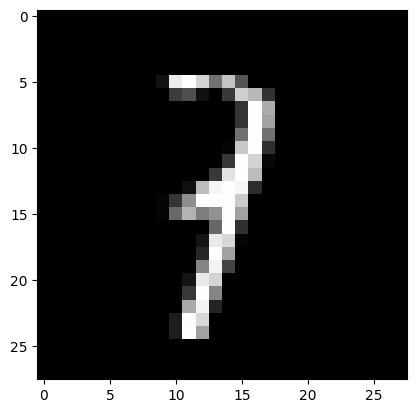

Model prediction: 1


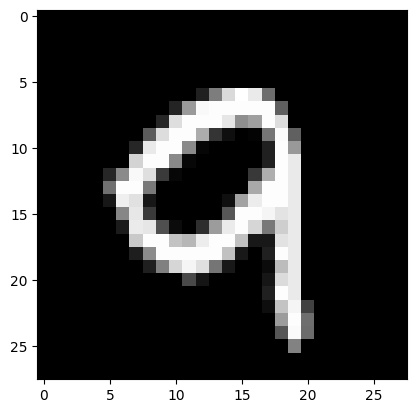

Model prediction: 9


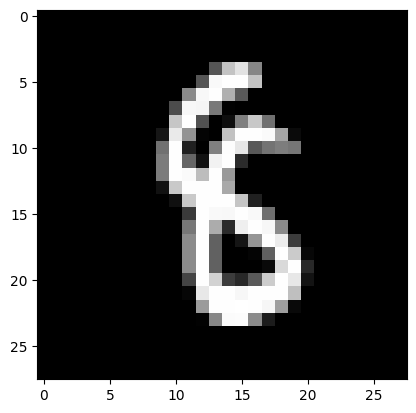

Model prediction: 8


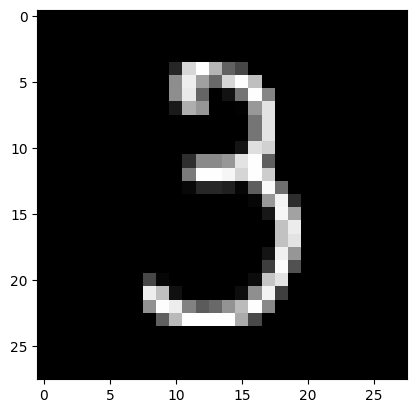

Model prediction: 3


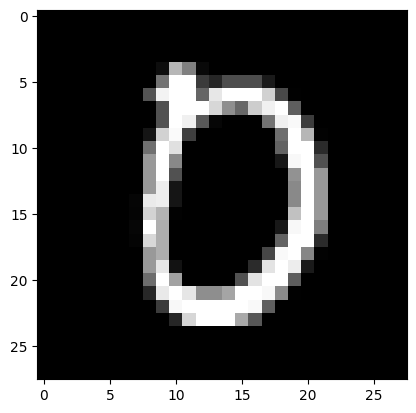

Model prediction: 0


In [19]:
# Predict 5 images from validation set.
n_images = 5
test_images = x_test[:n_images]
predictions = conv_net(test_images)

# Display image and model prediction.
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction: %i" % np.argmax(predictions.numpy()[i]))